In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

data_path = "results/Train curves"

In [106]:
version = 6
train_acc = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} train acc.csv")
val_acc = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} val acc.csv")
train_loss = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} train loss.csv")
val_loss = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} val loss.csv")

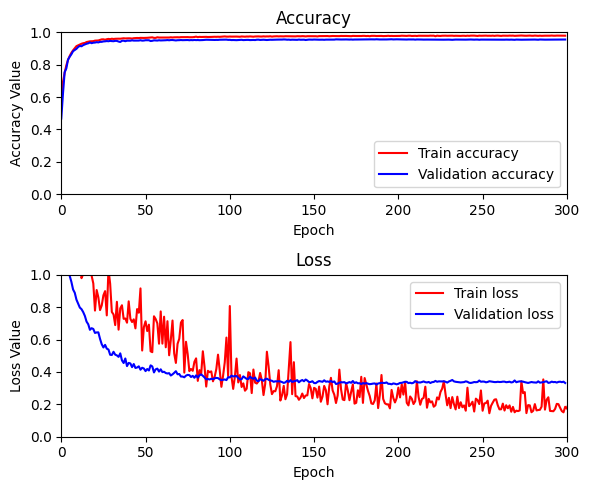

In [107]:
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Value")
plt.plot(train_acc.index,train_acc["Value"], label="Train accuracy", color="red")
plt.plot(val_acc.index,val_acc["Value"], label="Validation accuracy", color="blue")
plt.legend(loc='lower right')
plt.xlim(0,300)
plt.ylim(0,1.0)

plt.subplot(2,1,2)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(train_loss.index,train_loss["Value"], label="Train loss", color="red")
plt.plot(val_loss.index,val_loss["Value"], label="Validation loss", color="blue")
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.ylim(0,1.0)

plt.tight_layout()
plt.show()

In [108]:
version = 9
train_acc = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} train acc.csv")
val_acc = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} val acc.csv")
train_loss = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} train loss.csv")
val_loss = pd.read_csv(f"{data_path}/efficientnet-b0_32_version_{version} val loss.csv")

In [120]:
train_acc.head()

,Wall time,Step,Value
0,1.733968e+09,281,0.909810
1,1.733968e+09,328,0.922010
2,1.733968e+09,563,0.954080
3,1.733968e+09,704,0.961555
4,1.733968e+09,751,0.964345


In [ ]:
def load_csv(file_path):
    """Load a CSV file into a DataFrame."""
    return pd.read_csv(file_path)

def split_folds(data, column="step"):
    """
    Split the data into separate folds whenever the 'step' column decreases.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column used to detect fold splits.

    Returns:
        list of pd.DataFrame: A list of DataFrames, each representing a fold.
    """
    folds = []
    current_fold = []

    for i, row in data.iterrows():
        if i > 0 and row[column] < data.loc[i - 1, column]:
            folds.append(pd.DataFrame(current_fold, columns=data.columns))
            current_fold = []
        current_fold.append(row)

    if current_fold:  # Add the last fold
        folds.append(pd.DataFrame(current_fold, columns=data.columns))

    return folds

def process_metric(file_path, column="step", output_dir=None):
    """
    Process a single metric by splitting it into folds and optionally saving results.

    Args:
        file_path (str): Path to the CSV file.
        column (str): Column to detect fold splits.
        output_dir (str, optional): Directory to save fold CSVs. Defaults to None.

    Returns:
        list of pd.DataFrame: List of DataFrames representing folds.
    """
    data = load_csv(file_path)
    folds = split_folds(data, column)

    metric_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract file name without extension
    print(f"Processing metric: {metric_name}")
    for idx, fold in enumerate(folds):
        print(f"  Fold {idx + 1}: {len(fold)} rows")
        if output_dir:
            metric_dir = os.path.join(output_dir, metric_name)
            os.makedirs(metric_dir, exist_ok=True)
            fold.to_csv(os.path.join(metric_dir, f"fold_{idx + 1}.csv"), index=False)

    return folds

def process_all_metrics(file_paths, column="step", output_dir=None):
    """
    Process multiple metrics by splitting them into folds.

    Args:
        file_paths (list of str): List of file paths for the metrics.
        column (str): Column to detect fold splits.
        output_dir (str, optional): Directory to save fold CSVs. Defaults to None.

    Returns:
        dict: Dictionary where keys are metric names and values are lists of DataFrames (folds).
    """
    all_folds = {}
    for file_path in file_paths:
        metric_name = os.path.splitext(os.path.basename(file_path))[0]
        folds = process_metric(file_path, column, output_dir)
        all_folds[metric_name] = folds
    return all_folds

# Example Usage
file_paths = [
    "train_acc.csv",
    "val_acc.csv",
    "train_loss.csv",
    "val_loss.csv"
]  # Replace with your actual file paths

output_dir = "output_folds"  # Replace with your desired output directory or set to None
process_all_metrics(file_paths, column="step", output_dir=output_dir)


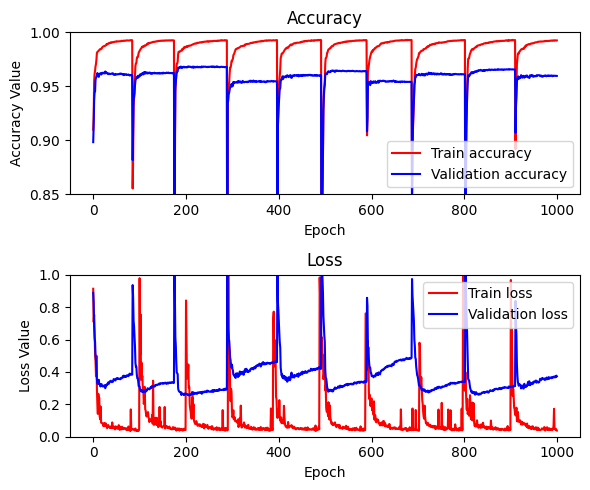

In [113]:
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Value")
plt.plot(train_acc.index,train_acc["Value"], label="Train accuracy", color="red")
plt.plot(val_acc.index,val_acc["Value"], label="Validation accuracy", color="blue")
plt.legend(loc='lower right')
# plt.xlim(0,300)
plt.ylim(0.85, 1.0)

plt.subplot(2,1,2)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(train_loss.index,train_loss["Value"], label="Train loss", color="red")
plt.plot(val_loss.index,val_loss["Value"], label="Validation loss", color="blue")
plt.legend(loc='upper right')
# plt.xlim(0,300)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

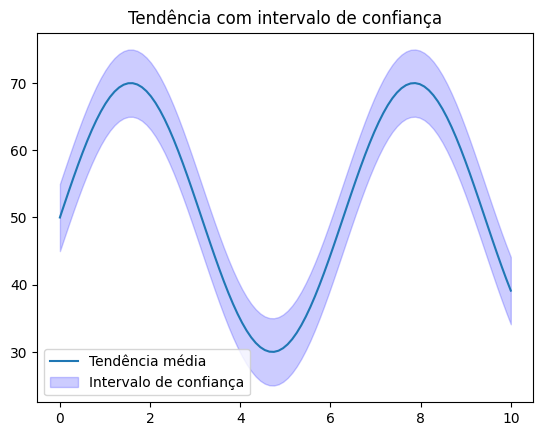

In [ ]:
# Dados simulados
x = np.linspace(0, 10, 100)
y = np.sin(x) * 20 + 50  # Tendência central
y_err = 5  # Margem de erro

plt.plot(x, y, label='Tendência média')
plt.fill_between(x, y - y_err, y + y_err, color='b', alpha=0.2, label='Intervalo de confiança')
plt.legend()
plt.title('Tendência com intervalo de confiança')
plt.show()